Primero, clonaremos tu repositorio de GitHub en el entorno de Colab:

In [4]:
!git clone https://github.com/ichiP245/micrography-imgpro.git

fatal: destination path 'micrography-imgpro' already exists and is not an empty directory.


Luego, agregaremos la carpeta del repositorio al `sys.path` de Python para que podamos importar el módulo `getmeresults`.

In [5]:
import sys
sys.path.append('/content/micrography-imgpro')

# Verifica que el módulo esté en la ruta antes de intentar importarlo
print("Python path updated. Trying to import getmeresults...")

Python path updated. Trying to import getmeresults...


Importamos librerías

In [6]:
import getmeresults as gmr
import cv2
import matplotlib.pyplot as plt
import os
import pandas as pd

In [9]:
# Funciones que vamos a usar

# Esta es para recortar la parte de abajo de las imagenes que es la etiqueta con los datos, o sea algo que debemos quitar
def read_and_crop_image(path):
    import cv2, numpy as np
    img = cv2.imread(path)
    h, w = img.shape[:2]
    img = img[:h-290, :, :]  # or use auto-detection like above
    return img

def getSegmentationFigure(segmentation, percentages, filename, ax=None):
    if ax is None:
        fig = plt.figure(figsize=(14, 8))
        ax = fig.add_subplot(111)

    im = ax.imshow(segmentation)
    ax.axis('off')

    # Agregar la barra de color con etiquetas personalizadas
    cbar = fig.colorbar(im, ax=ax, orientation="vertical", shrink=0.4)
    cbar.set_ticks([20,60,150,250])
    cbar.set_ticklabels([
        f"Indefinido - {percentages['undefined']:.2f}%",
        f"Poros - {percentages['pores']:.2f}%",
        f"Resina - {percentages['resin']:.2f}%",
        f"Fibra - {percentages['fibers']:.2f}%"
        ])
    ax.set_title(f"Segmentación - {filename}")
    plt.tight_layout()

Hacemos una prueba con una imagen subida al GitHub.

Los resultados son parecidos pero no iguales, ademas porque en el GitHub se le pusieron otras etiquetas a la composicion del tubo de fibra de vidrio.

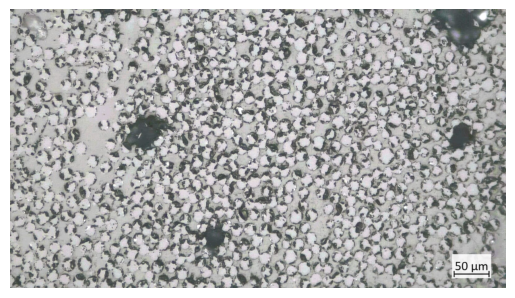

In [7]:
imagen_prueba = cv2.imread('/content/frb-003.jpg')

if imagen_prueba is None:
    print("Error: Could not load image. Please check the path and file existence.")
else:
    # Convert BGR image to RGB for matplotlib display
    imagen_prueba_rgb = cv2.cvtColor(imagen_prueba, cv2.COLOR_BGR2RGB)
    plt.imshow(imagen_prueba_rgb)
    plt.axis('off')
    plt.show()

grayscale_image = cv2.cvtColor(imagen_prueba, cv2.COLOR_RGB2GRAY)
perc, seg, col = gmr.getMeResults(grayscale_image)

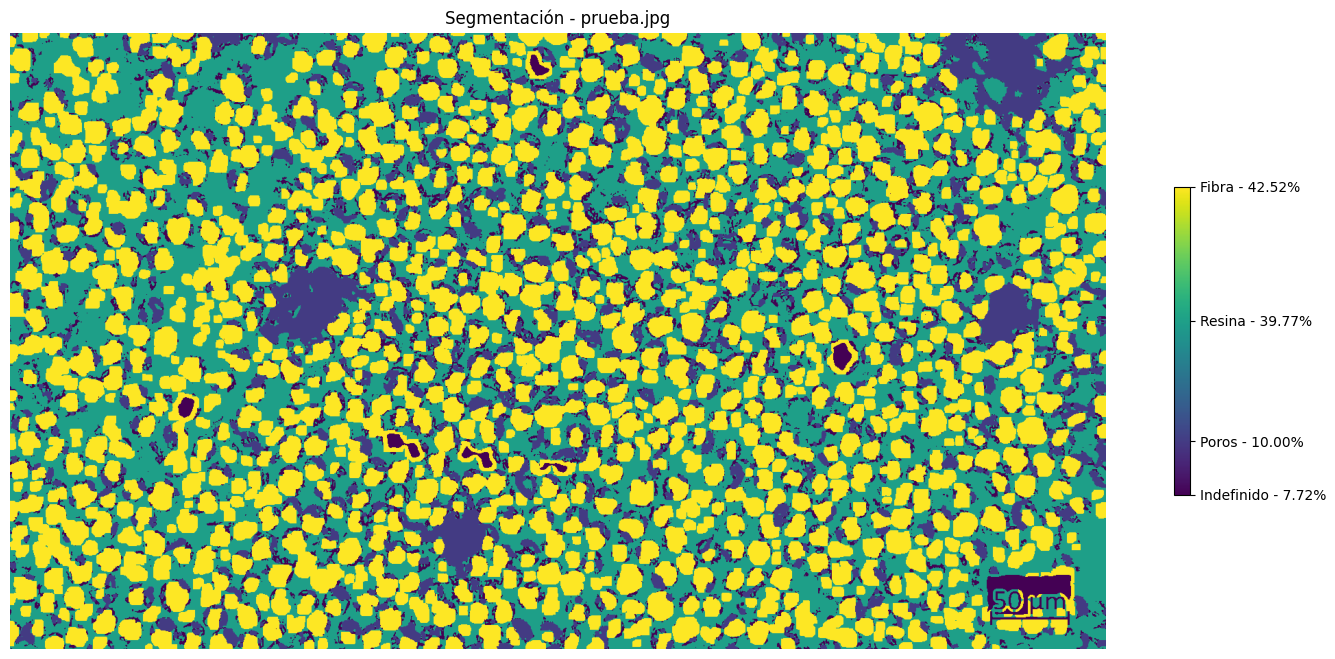

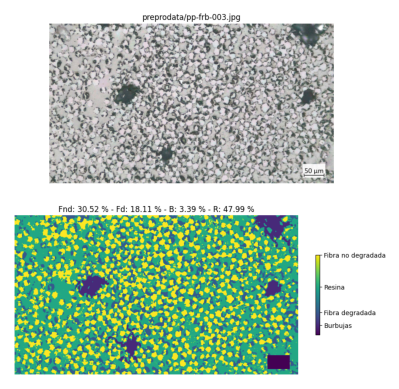

In [10]:
getSegmentationFigure(seg, perc, 'prueba.jpg')
plt.show()

comparacion_rgb = cv2.cvtColor(cv2.imread('/content/Comparacion.png'), cv2.COLOR_BGR2RGB)
plt.imshow(comparacion_rgb)
plt.axis('off')
plt.show()

Empezamos a hacer nuestro analisis

## Tanda 2024

Importamos imagenes con Google Drive

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
# Carpeta en Google Drive -> Tubo 2024
folder_path = '/content/drive/MyDrive/Micrografía M2 31 3 2025'
list_path_imgs = []
for item_name in os.listdir(folder_path):
    item_path = os.path.join(folder_path, item_name)
    if os.path.isfile(item_path):
        if len(item_name) < 22:
          print(f"File: {item_name} not added")
        else:
          list_path_imgs.append(item_path)
    elif os.path.isdir(item_path):
        print(f"Directory: {item_name}")

File: Experiment-769.jpg not added
File: Resina.jpg not added
File: Experiment-814.jpg not added


Definimos parametros

In [13]:
global_parameters = {
    'first_kernel_size': (5,5),
    'second_kernel_size': (3,3),
    'contours_mult': 2.5,
    'bh_ks': (7,7),
    'bhm_iter': 4,
    'bhm_mult': 60,
    'cont_mult': 2.5,
    'ws_ths_factor': 0.025,
    'ws_gl_vecinity': 15}

Vemos que las imagenes recortadas no hayan sacado contenido, sino unicamente el margen inferior que no sirve

In [ ]:
# Esta celda la comentamos. Al correrla vemos para cada imagen que tenemos que recortar,
# "la imagen original - la imagen recortada". Al correrlo comprobamos que estan bien recortadas

# for img_path in list_path_imgs:
#     # Read the original image
#     original_img = cv2.imread(img_path)

#     # Get the cropped image using the defined function
#     cropped_img = read_and_crop_image(img_path)

#     # Convert images from BGR to RGB for matplotlib display
#     original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
#     cropped_img_rgb = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)

#     # Display original and cropped images side-by-side
#     plt.figure(figsize=(15, 7))

#     plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
#     plt.imshow(original_img_rgb)
#     plt.title(f"Original: {os.path.basename(img_path)}")
#     plt.axis('off')

#     plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
#     plt.imshow(cropped_img_rgb)
#     plt.title("Recortada")
#     plt.axis('off')

#     plt.show()

# # Todas las imagenes quedaron bien recortadas

Guardamos las imagenes

In [14]:
list_cropped_imgs = []
for img_path in list_path_imgs:
  # Recortamos la imagen
  cropped_img = read_and_crop_image(img_path)
  cropped_img_rgb = cv2.cvtColor(cropped_img, cv2.COLOR_RGB2GRAY)
  list_cropped_imgs.append(cropped_img_rgb)

Volvemos a definir getMeResults para que no calcule la parte de segmentacion y coloracion que no vamos a usar. Solo quiero que me devuelva los porcentajes

In [17]:
import cv2
import numpy as np

import getmepores as gmp
import getmeflashes as gmfl
import getmefibers as gmf

def getMeResults_bis(base_img, parameters = {
    'first_kernel_size': (5,5),
    'second_kernel_size': (3,3),
    'contours_mult': 2.5,
    'bh_ks': (7,7),
    'bhm_iter': 4,
    'bhm_mult': 60,
    'cont_mult': 2.5,
    'ws_ths_factor': 0.025,
    'ws_gl_vecinity': 15,
}):

    pores_mask, undefined_mask = gmp.getMetPores(base_img,
                                                first_kernel_size=parameters['first_kernel_size'],
                                                second_kernel_size=parameters['second_kernel_size'])

    flashes_mask = gmfl.getMeFlashes(base_img,cont_mult=parameters['cont_mult'])

    fibers_mask, _, _ = gmf.getMeFibers(base_img,bh_ks=parameters['bh_ks'],
                                        bhm_iter=parameters['bhm_iter'],
                                        bhm_mult=parameters['bhm_mult'],
                                        cont_mult=parameters['cont_mult'],
                                        ws_ths_factor=parameters['ws_ths_factor'],
                                        ws_gl_vecinity=parameters['ws_gl_vecinity'])

    # Se completa la máscara de objetos indefinidos
    undefined_mask_complete = np.zeros(np.shape(base_img), dtype=np.uint8)
    undefined_mask_complete[undefined_mask == 255] = 255
    undefined_mask_complete[flashes_mask == 255] = 255

    # Se refina la máscara de fibras
    fibers_mask_complete = fibers_mask.copy()
    fibers_mask_complete[pores_mask == 255] = 0
    fibers_mask_complete[undefined_mask_complete == 255] = 0

    # Se obtiene la máscara de resina y se refina
    resin_mask = cv2.bitwise_not(fibers_mask_complete)
    resin_mask[pores_mask == 255] = 0
    resin_mask[undefined_mask_complete == 255] = 0

    # Cálculos
    total_pixels = base_img.shape[0] * base_img.shape[1]
    total_pores = np.sum(pores_mask == 255)
    total_fibers = np.sum(fibers_mask_complete == 255)
    total_resin = np.sum(resin_mask == 255)
    total_undefined = np.sum(undefined_mask_complete == 255)

    percentages = {
        'pores': (total_pores / total_pixels) * 100,
        'fibers': (total_fibers / total_pixels) * 100,
        'resin': (total_resin / total_pixels) * 100,
        'undefined': (total_undefined / total_pixels) * 100,
        'sumcheck': (total_pores + total_fibers + total_resin + total_undefined) / total_pixels * 100
    }

    return percentages

Obtenemos para cada imagen los porcentajes de cada uno de los componentes y lo guardamos en un diccionario con el path de la imagen como clave.

Tarda aprox 1 minuto por imagen en calcular los porcentajes

In [18]:
dict_results = dict()
for i in range(len(list_path_imgs)):
  path_image = list_path_imgs[i]
  grayscale_image = list_cropped_imgs[i]
  perc = getMeResults_bis(grayscale_image, global_parameters)
  dict_results[path_image] = perc
  print(f"Image number {i}: {list_path_imgs[i]} COMPLETED")

Image number 0: /content/drive/MyDrive/Micrografía M2 31 3 2025/Experiment-769--02.jpg COMPLETED
Image number 1: /content/drive/MyDrive/Micrografía M2 31 3 2025/Experiment-769--01.jpg COMPLETED
Image number 2: /content/drive/MyDrive/Micrografía M2 31 3 2025/Experiment-769--07.jpg COMPLETED
Image number 3: /content/drive/MyDrive/Micrografía M2 31 3 2025/Experiment-769--06.jpg COMPLETED
Image number 4: /content/drive/MyDrive/Micrografía M2 31 3 2025/Experiment-769--04.jpg COMPLETED
Image number 5: /content/drive/MyDrive/Micrografía M2 31 3 2025/Experiment-769--03.jpg COMPLETED
Image number 6: /content/drive/MyDrive/Micrografía M2 31 3 2025/Experiment-769--05.jpg COMPLETED
Image number 7: /content/drive/MyDrive/Micrografía M2 31 3 2025/Experiment-769--11.jpg COMPLETED
Image number 8: /content/drive/MyDrive/Micrografía M2 31 3 2025/Experiment-769--09.jpg COMPLETED
Image number 9: /content/drive/MyDrive/Micrografía M2 31 3 2025/Experiment-769--12.jpg COMPLETED
Image number 10: /co

Lo guardamos en un dataframe y lo descargamos

In [20]:
df_results24 = pd.DataFrame(dict_results).T

In [22]:
df_results24.reset_index(inplace=True)
df_results24.rename(columns={'index': 'Image Paths'}, inplace=True)

In [24]:
df_results24['Tanda'] = 'Tubos 2024'

In [25]:
# df_results24.to_csv('df_results24.csv')

In [26]:
df_results24.head()

,Image Paths,pores,fibers,resin,undefined,sumcheck,Tanda
0,/content/drive/MyDrive/Micrografía M2 31 3 20...,0.000000,29.094329,64.121528,6.784144,100.0,Tubos 2024
1,/content/drive/MyDrive/Micrografía M2 31 3 20...,1.867573,64.227527,30.862606,3.042294,100.0,Tubos 2024
2,/content/drive/MyDrive/Micrografía M2 31 3 20...,6.011863,33.776427,53.767458,6.444252,100.0,Tubos 2024
3,/content/drive/MyDrive/Micrografía M2 31 3 20...,5.026331,34.344522,54.051119,6.578029,100.0,Tubos 2024
4,/content/drive/MyDrive/Micrografía M2 31 3 20...,0.000000,30.568528,63.969811,5.461661,100.0,Tubos 2024


In [30]:
df_results24['Image Paths'][0]

'/content/drive/MyDrive/Micrografía M2 31 3 2025/Experiment-769--02.jpg'

In [31]:
list_path_imgs[0]

'/content/drive/MyDrive/Micrografía M2 31 3 2025/Experiment-769--02.jpg'

## Tanda 2025 (simil 2026) -> ver

## Tanda 2025 (cercana a la final)

In [34]:
folder_path3 = '/content/drive/MyDrive/Micrografía Tubo F2 4 4 2025'
list_path_imgs_3 = []
for item_name in os.listdir(folder_path3):
    item_path = os.path.join(folder_path3, item_name)
    if os.path.isfile(item_path):
        list_path_imgs_3.append(item_path)
    elif os.path.isdir(item_path):
        print(f"Directory: {item_name}")

In [36]:
print('Longitud inicial:', len(list_path_imgs_3))
list_path_imgs_3 = [item for item in list_path_imgs_3 if '820' in item]
print('Longitud final (post eliminar las 2 imagenes que no eran del Experimento 820):', len(list_path_imgs_3))

Longitud inicial: 14
Longitud final (post eliminar las 2 imagenes que no eran del Experimento 820): 12


In [ ]:
# # Esta celda la comentamos. Al correrla vemos para cada imagen que tenemos que recortar,
# # "la imagen original - la imagen recortada". Al correrlo comprobamos que estan bien recortadas

# for img_path in list_path_imgs_3:
#     # Read the original image
#     original_img = cv2.imread(img_path)

#     # Get the cropped image using the defined function
#     cropped_img = read_and_crop_image(img_path)

#     # Convert images from BGR to RGB for matplotlib display
#     original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
#     cropped_img_rgb = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)

#     # Display original and cropped images side-by-side
#     plt.figure(figsize=(15, 7))

#     plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
#     plt.imshow(original_img_rgb)
#     plt.title(f"Original: {os.path.basename(img_path)}")
#     plt.axis('off')

#     plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
#     plt.imshow(cropped_img_rgb)
#     plt.title("Recortada")
#     plt.axis('off')

#     plt.show()

# # Todas las imagenes quedaron bien recortadas

In [38]:
list_cropped_imgs_3 = []
for img_path in list_path_imgs_3:
  # Recortamos la imagen
  cropped_img = read_and_crop_image(img_path)
  cropped_img_rgb = cv2.cvtColor(cropped_img, cv2.COLOR_RGB2GRAY)
  list_cropped_imgs_3.append(cropped_img_rgb)

In [39]:
len(list_cropped_imgs_3) == len(list_path_imgs_3)

True

In [40]:
len(list_path_imgs_3)

12

In [41]:
dict_results3 = dict()
for i in range(len(list_path_imgs_3)):
  path_image = list_path_imgs_3[i]
  grayscale_image = list_cropped_imgs_3[i]
  perc = getMeResults_bis(grayscale_image, global_parameters)
  dict_results3[path_image] = perc
  print(f"Image number {i}: {list_path_imgs_3[i]} COMPLETED")

Image number 0: /content/drive/MyDrive/Micrografía Tubo F2 4 4 2025/Experiment-820--03.jpg COMPLETED
Image number 1: /content/drive/MyDrive/Micrografía Tubo F2 4 4 2025/Experiment-820--12.jpg COMPLETED
Image number 2: /content/drive/MyDrive/Micrografía Tubo F2 4 4 2025/Experiment-820--07.jpg COMPLETED
Image number 3: /content/drive/MyDrive/Micrografía Tubo F2 4 4 2025/Experiment-820--13.jpg COMPLETED
Image number 4: /content/drive/MyDrive/Micrografía Tubo F2 4 4 2025/Experiment-820--11.jpg COMPLETED
Image number 5: /content/drive/MyDrive/Micrografía Tubo F2 4 4 2025/Experiment-820--08.jpg COMPLETED
Image number 6: /content/drive/MyDrive/Micrografía Tubo F2 4 4 2025/Experiment-820--06.jpg COMPLETED
Image number 7: /content/drive/MyDrive/Micrografía Tubo F2 4 4 2025/Experiment-820--02.jpg COMPLETED
Image number 8: /content/drive/MyDrive/Micrografía Tubo F2 4 4 2025/Experiment-820--05.jpg COMPLETED
Image number 9: /content/drive/MyDrive/Micrografía Tubo F2 4 4 2025/Experiment-82

In [44]:
df_results25cercano = pd.DataFrame(dict_results3).T
df_results25cercano.reset_index(inplace=True)
df_results25cercano.rename(columns={'index': 'Image Paths'}, inplace=True)
df_results25cercano['Tanda'] = 'Tubos 2025 (cercana a la final)'

In [46]:
# df_results25cercano.to_csv('df_results25cercano.csv')

In [51]:
df_results25cercano.head()

,Image Paths,pores,fibers,resin,undefined,sumcheck,Tanda
0,/content/drive/MyDrive/Micrografía Tubo F2 4 ...,5.662423,50.493393,41.995611,1.848573,100.0,Tubos 2025 (cercana a la final)
1,/content/drive/MyDrive/Micrografía Tubo F2 4 ...,2.664448,56.736304,37.814815,2.784433,100.0,Tubos 2025 (cercana a la final)
2,/content/drive/MyDrive/Micrografía Tubo F2 4 ...,4.713445,49.414304,43.747155,2.125096,100.0,Tubos 2025 (cercana a la final)
3,/content/drive/MyDrive/Micrografía Tubo F2 4 ...,0.002411,38.644531,60.940731,0.412326,100.0,Tubos 2025 (cercana a la final)
4,/content/drive/MyDrive/Micrografía Tubo F2 4 ...,2.009983,52.405237,43.343123,2.241657,100.0,Tubos 2025 (cercana a la final)


In [48]:
df_results25cercano['Image Paths'][0]

'/content/drive/MyDrive/Micrografía Tubo F2 4 4 2025/Experiment-820--03.jpg'

In [50]:
list_path_imgs_3[0]

'/content/drive/MyDrive/Micrografía Tubo F2 4 4 2025/Experiment-820--03.jpg'